In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

## P4.2

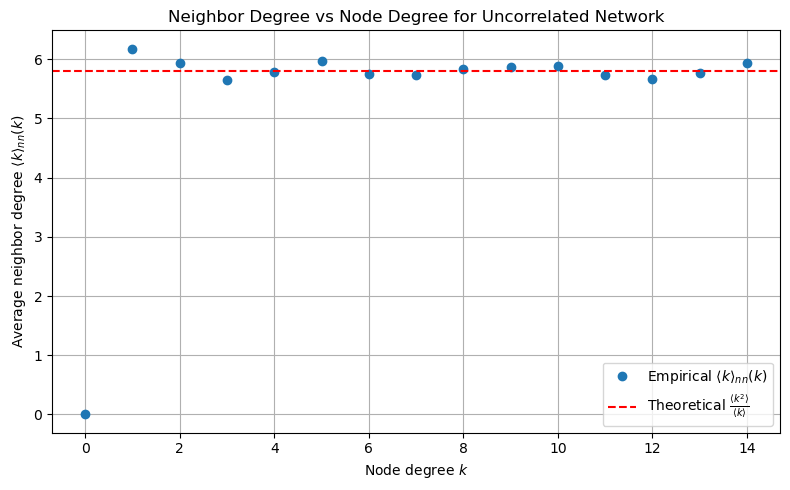

In [2]:
# random degree sequence
np.random.seed(42)
N = 1000
degree_sequence = np.random.poisson(5, N)
# is valid for simple graph?
while not nx.is_valid_degree_sequence_erdos_gallai(degree_sequence):
    degree_sequence = np.random.poisson(5, N)

# uncorrelated random network
G = nx.configuration_model(degree_sequence)
G = nx.Graph(G)
G.remove_edges_from(nx.selfloop_edges(G))

# compute theoretical
degrees = np.array([d for n, d in G.degree()])
k_avg = np.mean(degrees)
k2_avg = np.mean(degrees**2)
expected_knn = k2_avg / k_avg

# compute empirical
knn_dict = nx.average_degree_connectivity(G)
ki_vals = np.array(list(knn_dict.keys()))
knn_vals = np.array(list(knn_dict.values()))

# plot
plt.figure(figsize=(8, 5))
plt.plot(ki_vals, knn_vals, 'o', label=r'Empirical $\langle k \rangle_{nn}(k)$')
plt.axhline(expected_knn, color='r', linestyle='--', label=r'Theoretical $\frac{\langle k^2 \rangle}{\langle k \rangle}$')
plt.xlabel('Node degree $k$')
plt.ylabel(r'Average neighbor degree $\langle k \rangle_{nn}(k)$')
plt.title('Neighbor Degree vs Node Degree for Uncorrelated Network')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## P4.3

In [3]:
def compute_knn_dependence(G):
    # k_nn(k)
    knn_dict = nx.average_degree_connectivity(G)

    # extract degree and corresponding average neighbor degree
    degrees = sorted(knn_dict.keys())
    knn_values = [knn_dict[k] for k in degrees]

    # compute theoretical
    deg = np.array([d for n, d in G.degree()])
    k_avg = np.mean(deg)
    k2_avg = np.mean(deg**2)
    expected_knn = k2_avg / k_avg
    return degrees, knn_values, expected_knn

def analyze_knn_dependence(G, title="Network", num_switches=10000):
    degrees, knn_values, expected_knn = compute_knn_dependence(G)

    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(degrees, knn_values, marker='o', linestyle='-', color='teal')
    plt.axhline(expected_knn, color='r', linestyle='--', label=r'Theoretical $\frac{\langle k^2 \rangle}{\langle k \rangle}$')
    plt.xlabel("Degree k")
    plt.ylabel("Average Neighbor Degree k_nn(k)")
    plt.title(f"Average Neighbor Degree vs Degree in {title}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

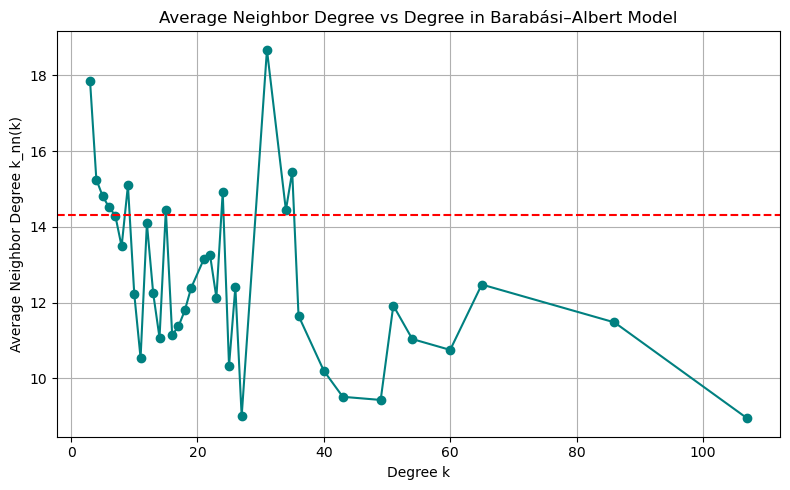

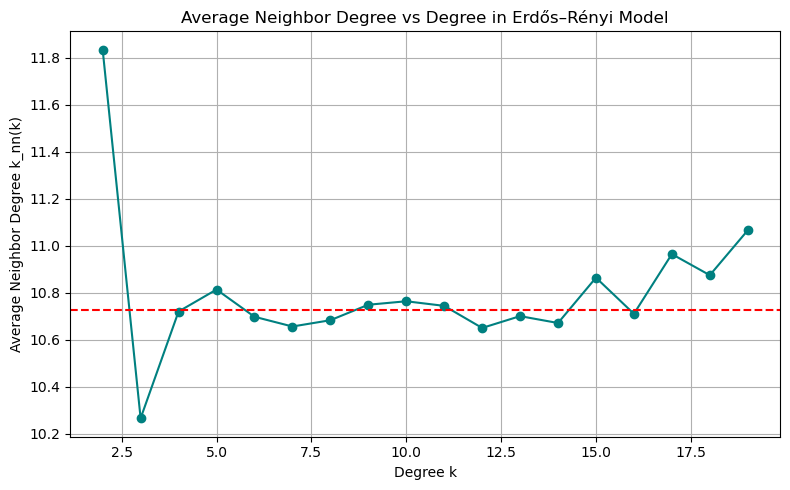

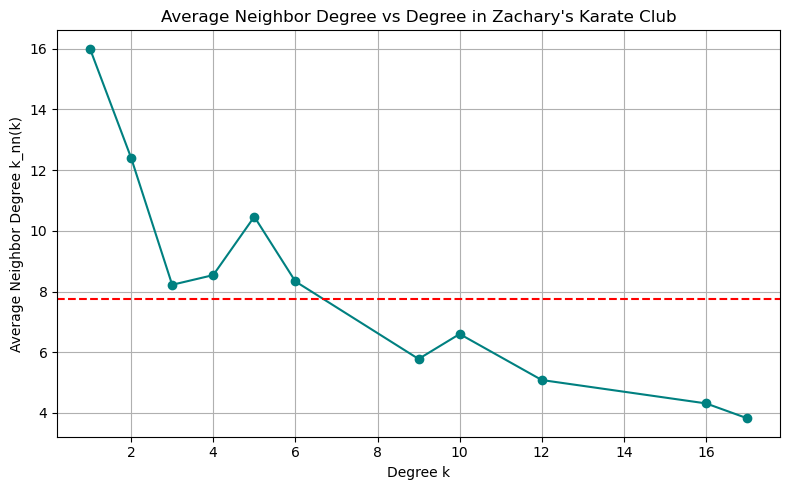

In [4]:
G_ba = nx.barabasi_albert_graph(n=1000, m=3)
analyze_knn_dependence(G_ba, title="Barabási–Albert Model")

G_er = nx.erdos_renyi_graph(n=1000, p=0.01)
analyze_knn_dependence(G_er, title="Erdős–Rényi Model")

G_karate = nx.karate_club_graph()
analyze_knn_dependence(G_karate, title="Zachary's Karate Club")

## P4.4

In [5]:
def compare_knn_dependence(G, title="Network", num_switches=10000):
    # original
    deg_orig, knn_orig, expected_knn = compute_knn_dependence(G)

    # randomized (degree-preserving)
    G_rand = G.copy()
    nx.double_edge_swap(G_rand, nswap=num_switches, max_tries=num_switches * 10)
    deg_rand, knn_rand, _ = compute_knn_dependence(G_rand)

    # plot
    plt.figure(figsize=(8, 5))
    plt.plot(deg_orig, knn_orig, marker='o', linestyle='-', label='Original', color='teal')
    plt.plot(deg_rand, knn_rand, marker='s', linestyle='-', label='Randomized', color='purple')
    plt.axhline(expected_knn, color='r', linestyle='--', label=r'Theoretical $\frac{\langle k^2 \rangle}{\langle k \rangle}$')
    plt.xlabel("Degree k")
    plt.ylabel("Average Neighbor Degree k_nn(k)")
    plt.title(f"Effect of Edge Switching on {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

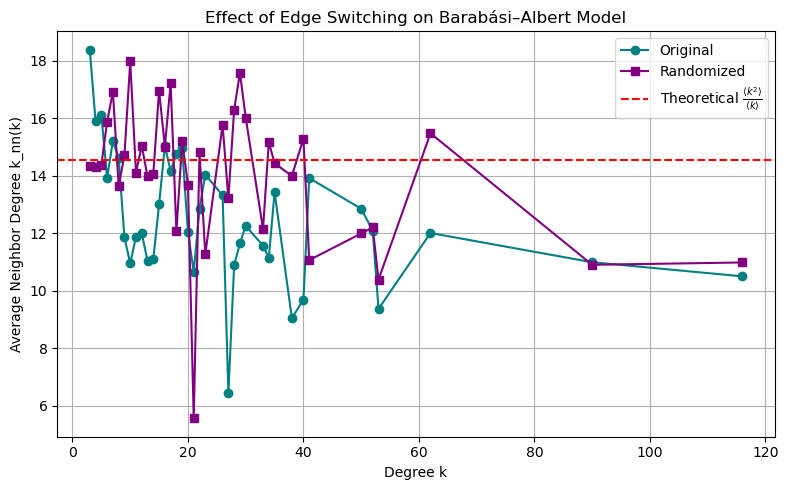

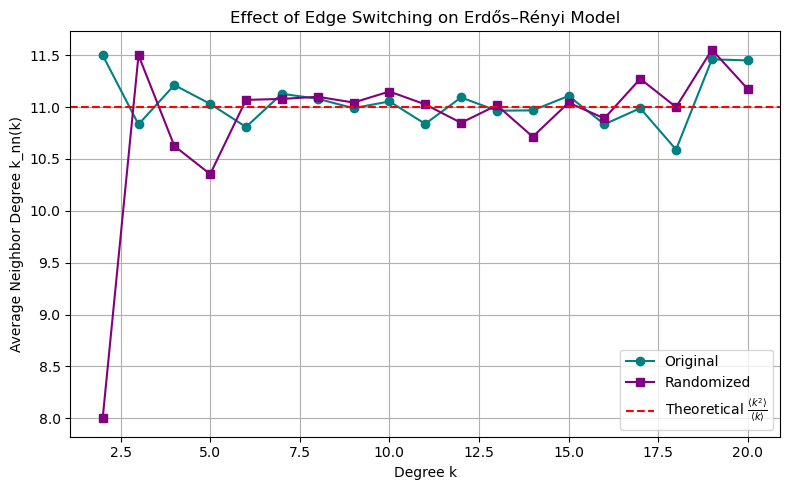

In [6]:
G_ba = nx.barabasi_albert_graph(n=1000, m=3)
compare_knn_dependence(G_ba, title="Barabási–Albert Model")

G_er = nx.erdos_renyi_graph(n=1000, p=0.01)
compare_knn_dependence(G_er, title="Erdős–Rényi Model")

## P4.6

In [7]:
def compute_assortativity(G, label="Network"):
    r = nx.degree_assortativity_coefficient(G)
    print(f"{label} assortativity coefficient: {r:.4f}")
    return r

def compare_assortativity_with_switching(G, label="Network", num_switches=10000):
    # original
    r_original = compute_assortativity(G, label + " (Original)")

    # randomized
    G_rand = G.copy()
    nx.double_edge_swap(G_rand, nswap=num_switches, max_tries=num_switches * 10)
    r_randomized = compute_assortativity(G_rand, label + " (Randomized)")

    return r_original, r_randomized

In [11]:
G_ba = nx.barabasi_albert_graph(n=1000, m=3)
compare_assortativity_with_switching(G_ba, label="Barabási–Albert Model")

G_er = nx.erdos_renyi_graph(n=1000, p=0.01)
compare_assortativity_with_switching(G_er, label="Erdős–Rényi Model")
print("")

Barabási–Albert Model (Original) assortativity coefficient: -0.0692
Barabási–Albert Model (Randomized) assortativity coefficient: -0.0499
Erdős–Rényi Model (Original) assortativity coefficient: -0.0085
Erdős–Rényi Model (Randomized) assortativity coefficient: -0.0166



## P4.7

In [9]:
import powerlaw

def compute_network_metrics(G, name):
    N = G.number_of_nodes()
    E = G.number_of_edges()
    alpha = powerlaw.Fit([d for n, d in G.degree()], discrete=True).power_law.alpha
    avg_k = sum(dict(G.degree()).values()) / N
    directed = nx.is_directed(G)
    try:
        l = nx.average_shortest_path_length(G)
    except nx.NetworkXError:
        l = None  # not connected then
    r = nx.degree_assortativity_coefficient(G)
    return {
        "Network": name,
        "directed": directed,
        "N": N,
        "E": E,
        "⟨k⟩": round(avg_k, 2),
        "alpha": round(alpha, 2),
        "l": round(l, 2) if l else "N/A",
        "r": round(r, 3)
    }

In [12]:
G_karate = nx.karate_club_graph()
G_lesmis = nx.les_miserables_graph()
G_davis = nx.davis_southern_women_graph()
G_as = nx.read_edgelist("as20000102.txt")

networks = [
    compute_network_metrics(G_karate, "Zachary Karate Club"),
    compute_network_metrics(G_lesmis, "Les Misérables"),
    compute_network_metrics(G_davis, "Davis Southern Women"),
    compute_network_metrics(G_as, "Autonomous Systems 02.01.2000")
]

print(f"{'Network':<30} {'directed?':>5} {'N':>3} {'E':>5} {'⟨k⟩':>6} {'alpha':>8} {'l':>4} {'r':>6}")
for net in networks:
    print(f"{net['Network']:<30} {net['directed']:>5} {net['N']:>8} {net['E']:>5} {net['⟨k⟩']:>6} {net['alpha']:>6} {net['l']:>6} {net['r']:>6}")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Network                        directed?   N     E    ⟨k⟩    alpha    l      r
Zachary Karate Club                0       34    78   4.59   2.09   2.41 -0.476
Les Misérables                     0       77   254    6.6   4.09   2.64 -0.165
Davis Southern Women               0       32    89   5.56   5.69   2.31 -0.337
Autonomous Systems 02.01.2000      0     6474 13895   4.29   2.14   3.71  -0.17


Karate (78) https://networks.skewed.de/net/karate
Autonomus https://snap.stanford.edu/data/as-733.html
Les Miserables https://networks.skewed.de/net/lesmis
